# Simulació parking: descoberta de patrons amb clustering

## Introducció

Aquesta és la versió **quadern de Jupyter** del script clusteringsklearn.py. D'aquesta manera es vol posar de manifest com resolem el mateix problema tant en *quadern* com en *script*. Els avantatges i els inconvenients. El quadern de Jupyter és més narratiu i interactiu, es pot executar a trossos, pot integrar les imatges dins dels quadern. El script es pot executar des de la consola i la seva execució es pot integrar en un context de projecte més ampli.

Tenim un script per generar entrades i sortides a un parking d'un llistat de cotxes. En aquest script s'ha simulat 4 comportaments de cotxes:

- Tipus I: cotxes de cap de setmana vespre (franja 20-02)
- Tipus II: cotxes diumenge matí (franja 9-14)
- Tipus III: cotxes de dies feiners (franja 08-16)
- Tipus IV: cotxes esporàdics (és el gruix de cotxes, seria com soroll que s'afegeix als altres grups)

Volem aplicar un algorisme de clustering per veure si podem separar els 4 grups. És un cas d'aprenentatge no supervisat: tenim unes dades, i volem veure com afloren els agrupaments de tipus de comportament.

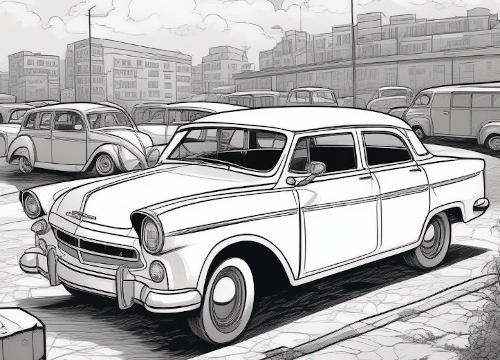

In [1]:
from PIL import Image
img = Image.open(r'img/cotxe_500.png')
display(img)

In [2]:
import pandas as pd

## Dataset i EDA (Exploratory Data Analysis)

In [3]:
# el fitxer registre_durada.csv s'ha generat a partir del script de simulació
path_to_file = 'data/registre_durada.csv'
parking_data = pd.read_csv(path_to_file, delimiter=';')

El dataset és un registre d'entrades i sortides de cotxes. Després d'un cert temps (en la simulació s'ha realitzat sobre l'any 2023) ja s'ha acumulat prou informació per intentar treure patrons de comportament. Per exemple, cotxes que fan servir el parking per anar a treballar en dies feiners, cotxes que fan servir el parking per anar al cinema el cap de setmana al vespre, etc.

In [4]:
parking_data.shape

(19358, 7)

In [5]:
parking_data[:5]

,matricula,tipus,dia_hora,durada,hora,dia_setmana,dia_setmana_dec
0,9067 SAG,1,2023-05-13 22:19:53,13375,22.3,5,5.9
1,9067 SAG,1,2023-09-03 19:27:16,10769,19.5,6,6.8
2,9067 SAG,1,2023-09-16 21:37:16,8207,21.6,5,5.9
3,9067 SAG,1,2023-06-17 21:15:55,11190,21.3,5,5.9
4,9067 SAG,1,2023-02-04 21:00:15,10171,21.0,5,5.9


In [6]:
parking_data.columns

Index(['matricula', 'tipus', 'dia_hora', 'durada', 'hora', 'dia_setmana',
       'dia_setmana_dec'],
      dtype='object')

In [7]:
parking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19358 entries, 0 to 19357
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   matricula        19358 non-null  object 
 1   tipus            19358 non-null  int64  
 2   dia_hora         19358 non-null  object 
 3   durada           19358 non-null  int64  
 4   hora             19358 non-null  float64
 5   dia_setmana      19358 non-null  int64  
 6   dia_setmana_dec  19358 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1.0+ MB


Eliminem columnes que no interessen:

In [8]:
parking_data = parking_data.drop('dia_hora', axis=1)
parking_data = parking_data.drop('dia_setmana', axis=1)
parking_data[:3]

,matricula,tipus,durada,hora,dia_setmana_dec
0,9067 SAG,1,13375,22.3,5.9
1,9067 SAG,1,10769,19.5,6.8
2,9067 SAG,1,8207,21.6,5.9


## Etiquetes de les dades

El clustering és aprenentatge no-supervisat. Ara bé, en aquest cas, com que és una simulació, tenim les etiquetes dels cotxes (sabem a quina classe pertany). Això ens servirà per poder avaluar el model de clustering. El primer que fem és guardar els *true-labels*.

In [9]:
df_true_labels = parking_data.groupby(['matricula']).mean()
df_true_labels = df_true_labels.astype({'tipus': int})
true_labels = df_true_labels["tipus"].to_numpy()
# eliminem el tipus, ja no interessa
parking_data = parking_data.drop('tipus', axis=1)
true_labels[:3]

array([3, 2, 4])

array([3, 2, 4])

## Agrupació dels cotxes (group by)

El dataset és un conjunt d'entrades i sortides de cotxes d'un parking. Però el que per nosaltres té importància és agrupar els cotxes (*group by*) per veure el comportament que tenen i estudiar si hi ha diferents patrons. Esperem veure que hi ha cotxes que utilitzen el parking el cap de setmana; d'altres els dies feiners per anar a treballar; etc.

In [10]:
parking_data_gb = parking_data.groupby(['matricula']).mean()
parking_data_gb = parking_data_gb.merge(parking_data.groupby(['matricula']).count()['durada'], how='inner', on='matricula')
parking_data_gb = parking_data_gb.rename(columns={'durada_x': 'durada', 'durada_y': 'count'})
parking_data_gb[:3]

,durada,hora,dia_setmana_dec,count
matricula,,,,
0001 DKR,21442.695652,9.053261,2.150000,92
0007 QNR,11263.631579,10.515789,6.442105,19
0015 CIQ,7610.200000,14.360000,2.110000,10


## Normalització de les dades

Les dades s'han de normalitzar doncs el valor de *durada* (en segons, de l'ordre de milers) estè en un ordre de magnitud diferent de les altres dades numèriques.

In [11]:
# normalització manual

#parking_data_gb_norm = parking_data_gb.copy()
#parking_data_gb_norm['durada'] = parking_data_gb['durada']/parking_data_gb['durada'].max()
#parking_data_gb_norm['hora'] = parking_data_gb['hora']/24
#parking_data_gb_norm['dia_setmana_dec'] = parking_data_gb['dia_setmana_dec']/7
#parking_data_gb_norm['count'] = parking_data_gb['count']/parking_data_gb['count'].max()
#parking_data_gb_norm[:3]

In [12]:
# normalització amb StandardScaler

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(parking_data_gb)
parking_data_gb_norm = pd.DataFrame(scaler.transform(parking_data_gb), index=parking_data_gb.index, columns=parking_data_gb.columns)

parking_data_gb_norm[:3]


,durada,hora,dia_setmana_dec,count
matricula,,,,
0001 DKR,2.706754,-0.935981,-1.286172,2.722038
0007 QNR,0.385650,-0.540143,1.697749,-0.013415
0015 CIQ,-0.447432,0.500305,-1.313981,-0.350663


Una altra forma de veure la informació de la que disposem:

In [13]:
parking_data_gb_norm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
durada,1000.0,-1.811884e-16,1.0005,-1.391814,-0.573177,-0.311663,0.195773,2.929748
hora,1000.0,2.557954e-16,1.0005,-2.284330,-0.692148,-0.244443,0.419785,2.387369
dia_setmana_dec,1000.0,-1.207923e-16,1.0005,-2.271055,-0.740431,-0.208594,0.538758,1.748693
count,1000.0,-2.131628e-17,1.0005,-0.612966,-0.500550,-0.425606,-0.088359,4.071028


## Visualitzar les dades

Per visualitzar les relacions que hi ha entre els diferents atributs del dataset podem utilitzar el mètode *pairplot* de la llibreria *seaborn*, que ens és molt últil. Si ens fixem bé ja es posa de manifest diferents agrupaments que esperem separar quan entrenem el model:

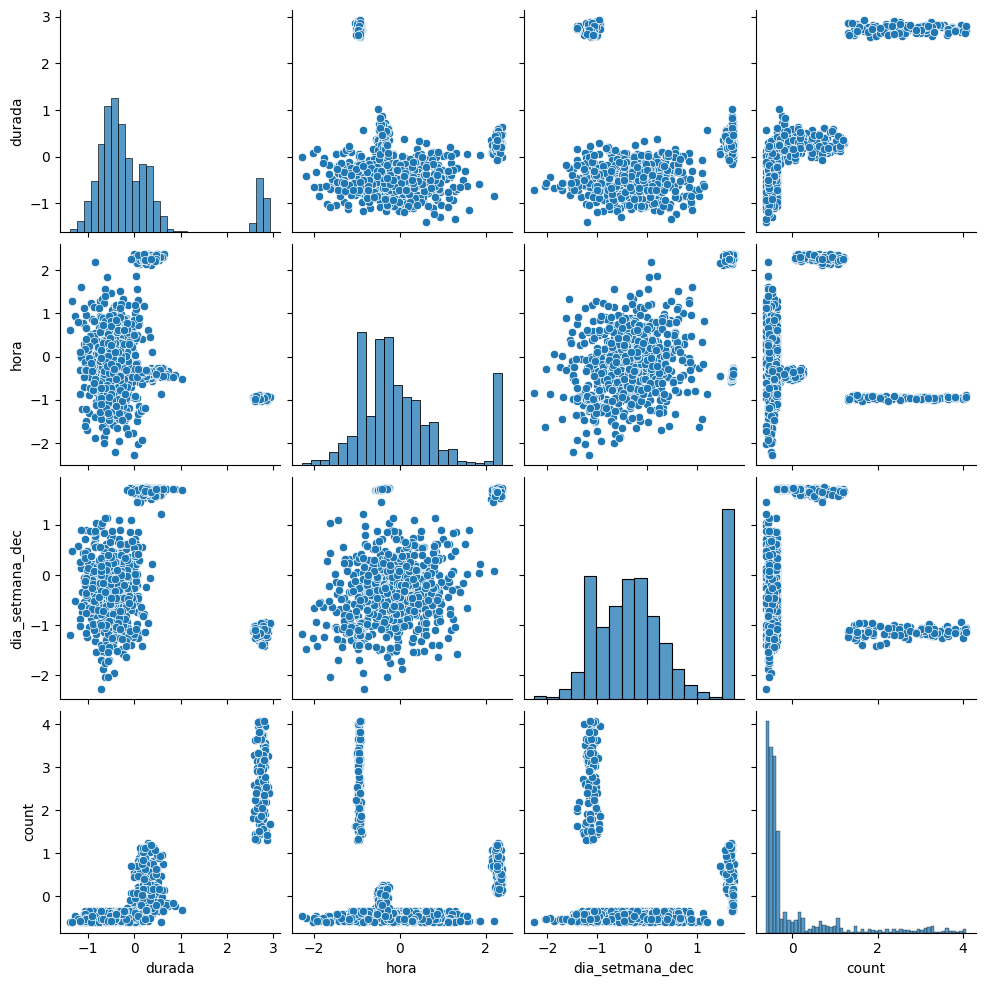

In [14]:
import seaborn as sns

sns.pairplot(parking_data_gb_norm)

## Clustering amb KMeans

Hi ha diferents algorismes per fer clustering de dades no-supervisades. En aquest cas farem servir KMeans.

In [15]:
# NOTA: s'ha provat tant el AgglomerativeClustering com el KMeans, i els resultats són similars (AgglomerativeClustering fins i tot millor que KMeans)
# tanmateix, s'escull KMeans perquè implementa el mètode predict() (cosa que no fa AgglomerativeClustering)
from sklearn.cluster import KMeans

# Selecting durada, hora, dia_setmana_dec, count
selected_data = parking_data_gb_norm.iloc[:, 0:4]

selected_data[:10]

,durada,hora,dia_setmana_dec,count
matricula,,,,
0001 DKR,2.706754,-0.935981,-1.286172,2.722038
0007 QNR,0.385650,-0.540143,1.697749,-0.013415
0015 CIQ,-0.447432,0.500305,-1.313981,-0.350663
0021 WMC,0.275154,2.248088,1.705282,1.185688
0032 QLG,-0.339763,0.575411,-0.008721,-0.425606
0048 JZI,-0.494041,-0.054535,0.006921,-0.350663
0066 UQW,0.385354,-0.415857,1.711927,0.173945
0066 WBR,-0.626889,-1.627030,-2.043953,-0.538022
0074 TVC,0.075117,2.294823,1.576529,0.436249


Ja podem entrenar el model. Podem provar diferents valors de *n_clusters*. Juguem amb avantatge provant *n_clusters=4* perquè aquest és el número de comportaments diferents que s'han programat en el script de simulació.

In [16]:
#clustering_model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clustering_model = KMeans(n_clusters=4,random_state=42)

clustering_model.fit(selected_data)

/home/joan/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

I ja disposem dels labels predits:

In [17]:
clustering_model.labels_[:3]

array([2, 1, 3], dtype=int32)

## Scores: homogeneity, completeness, v_measure

Com que havíem guardat els *true labels*, i ara tenim els *predicted labels*, podem valorar com de bé s'ha fet el procés de separar els grups:

In [18]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

print('Homogeneity: {:.3f}'.format(homogeneity_score(true_labels, clustering_model.labels_)))
print('Completeness: {:.3f}'.format(completeness_score(true_labels, clustering_model.labels_)))
print('V-measure: {:.3f}'.format(v_measure_score(true_labels, clustering_model.labels_)))

Homogeneity: 0.931
Completeness: 0.896
V-measure: 0.913


## Visualitzar els clústers/agrupaments

Efectivament hem trobat 4 agrupacions diferents que demostren el diferent comportament dels cotxes. Visualitzarem 3 gràfiques, cadascuna d'elles posarà de manifest diferents aspectes del comportament que estem estudiant.

Recordem que les dades estan normalitzades, i que visualitzem els valors mitjans de les dades. En aquesta primera gràfica podem localitzar a la dreta els cotxes que utilizen el parking els caps de setmana al vespre i el diumenge al matí. Al voltant de *dia_setmana_dec=-1* i *hora=-1* tenim els cotxes que entren al matí de dilluns a divendres, que són els cotxes que entren a treballar. Finalment, la majoria de punts és el soroll que representa els cotxes que fan servir el pàrking de manera esporàdica, sense cap mena de patró.

<Axes: xlabel='dia_setmana_dec', ylabel='hora'>

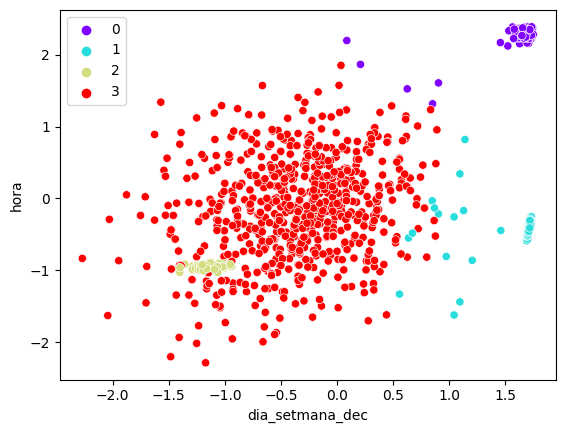

In [19]:
data_labels = clustering_model.labels_
sns.scatterplot(x='dia_setmana_dec', 
                y='hora', 
                data=selected_data, 
                hue=data_labels,
                palette="rainbow")

En la següent gràfica es visualitza la durada. És de comentar que els cotxes que utilitzen el parking en horari laboral (diguem de 8 a 16h) queden destacats amb una durada alta, i és un grup que queda clarament separat.

<Axes: xlabel='hora', ylabel='durada'>

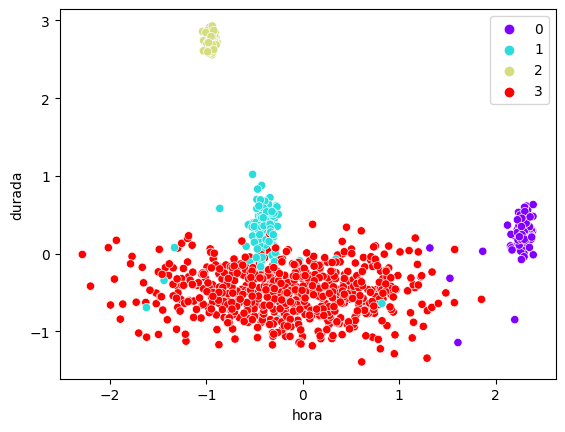

In [20]:
data_labels = clustering_model.labels_
sns.scatterplot(x='hora', 
                y='durada', 
                data=selected_data, 
                hue=data_labels,
                palette="rainbow")

La següent gràfica potser és la més clara de cara a distingir els 4 patrons de comportament.

*count*, el número de dies que fan servir el pàrking, és una mesura rellevant. Els cotxes esporàdics tenen un count baix i estan repartits per totes les hores. Els cotxes que van a treballar cada dia acostumen a fer-ho sempre o quasi sempre, i és per això que tenim un count alt (1-4). Els cotxes que fan servir el parking el diumenge al matí no entren a les 8h, sinó més aviat a les 11h, i ho fan de forma esporàdica (count baix). Finalment, els cotxes d'oci nocturn de cap de setmana (anar al cine, anar a sopar), l'hora és cap a les 21-22h, i el count és baix (comportament esporàdic però regular).

<Axes: xlabel='hora', ylabel='count'>

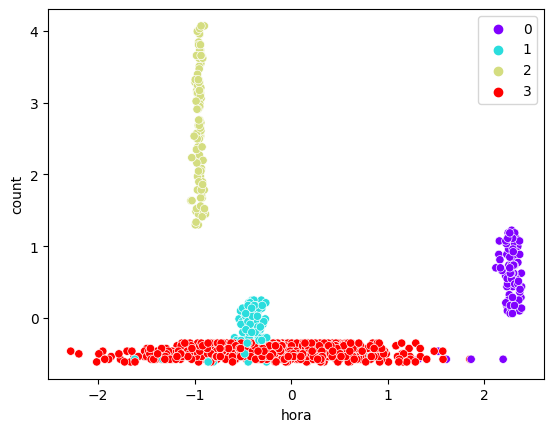

In [21]:
data_labels = clustering_model.labels_
sns.scatterplot(x='hora', 
                y='count', 
                data=selected_data, 
                hue=data_labels,
                palette="rainbow")

## Classificació d'un cotxe a una agrupació

Quan un cotxe entra al parking no es pot classificar. Només és quan aquest cotxe té un historial i ha fet servir el parking múltiples vegades podem assignar-lo a un dels clústers. NOTA: multipliquem per 8 aquestes mostres perquè les dades esta recollides d'un any sencer i el paràmetre count és un dels paràmetres amb què s'ha entrenat el dataset.

Anem a simular dos cotxes: el primer va al club de tennis el diumenge al matí; el segon acostuma a anar a sopar els dissabtes al vespre.

In [22]:
dades_cotxe = [
    ['6897 JWK', 12195, 12.2, 6.5],
    ['6897 JWK', 11881, 11.2, 6.5],
    ['6897 JWK', 12885, 11.5, 6.5],
    ['6897 JWK', 10549, 11.1, 6.5],
    ['6897 JWK', 2359, 11.6, 6.5],

    ['3560 ROQ', 7197, 21.5, 6.9],
    ['3560 ROQ', 4941, 21.1, 5.9],
    ['3560 ROQ', 13461, 20.1, 6.8],
    ['3560 ROQ', 13818, 19.4, 5.8],
    ['3560 ROQ', 11251, 19.9, 6.8]
]*2
    
df_dades_cotxe = pd.DataFrame(columns=['matricula', 'durada', 'hora', 'dia_setmana_dec'], data=dades_cotxe)
df_dades_cotxe

,matricula,durada,hora,dia_setmana_dec
0,6897 JWK,12195,12.2,6.5
1,6897 JWK,11881,11.2,6.5
2,6897 JWK,12885,11.5,6.5
3,6897 JWK,10549,11.1,6.5
4,6897 JWK,2359,11.6,6.5
5,3560 ROQ,7197,21.5,6.9
6,3560 ROQ,4941,21.1,5.9
7,3560 ROQ,13461,20.1,6.8
8,3560 ROQ,13818,19.4,5.8
9,3560 ROQ,11251,19.9,6.8


Agrupament de les dades:

In [23]:
df_dades_cotxe_gb = df_dades_cotxe.groupby(['matricula']).mean()
df_dades_cotxe_gb = df_dades_cotxe_gb.merge(df_dades_cotxe.groupby(['matricula']).count()['durada'], how='inner', on='matricula')
df_dades_cotxe_gb = df_dades_cotxe_gb.rename(columns={'durada_x': 'durada', 'durada_y': 'count'})
df_dades_cotxe_gb

,durada,hora,dia_setmana_dec,count
matricula,,,,
3560 ROQ,10133.6,20.40,6.44,10
6897 JWK,9973.8,11.52,6.50,10


Passem les dades pel normalitzador:

In [24]:
# normalització amb StandardScaler
df_dades_cotxe_gb_norm = pd.DataFrame(scaler.transform(df_dades_cotxe_gb), index=df_dades_cotxe_gb.index, columns=df_dades_cotxe_gb.columns)

df_dades_cotxe_gb_norm[:3]

,durada,hora,dia_setmana_dec,count
matricula,,,,
3560 ROQ,0.127972,2.135050,1.696285,-0.350663
6897 JWK,0.091533,-0.268351,1.737998,-0.350663


In [25]:
nova_prediccio = clustering_model.predict(df_dades_cotxe_gb_norm)
nova_prediccio

array([0, 1], dtype=int32)

El cotxe 3560 ROQ es correspon al clúster de *caps de setmana vespre*; el cotxe 6897 JWK es correspon al clúster de *diumenges matí*. Compte perquè el *group by* ens ha canviat l'ordre:

In [26]:
print('{}: label {}'.format(df_dades_cotxe_gb_norm.index[0], nova_prediccio[0]))
print('{}: label {}'.format(df_dades_cotxe_gb_norm.index[1], nova_prediccio[1]))

3560 ROQ: label 0
6897 JWK: label 1


## Generació d'informe de cotxes

Hem aconseguit fer la separació dels clústers, i sabem assignar un cotxe que té prou informació a un dels clústers.

Ara volem fer un llistat (informe) de tots els grups, la relació de cotxes que pertany a cada grup.

In [27]:
parking_data_gb[:3]

,durada,hora,dia_setmana_dec,count
matricula,,,,
0001 DKR,21442.695652,9.053261,2.150000,92
0007 QNR,11263.631579,10.515789,6.442105,19
0015 CIQ,7610.200000,14.360000,2.110000,10


In [28]:
clustering_model.labels_[:3]

array([2, 1, 3], dtype=int32)

Afegim la columna label:

In [29]:
parking_data_gb['label'] = clustering_model.labels_.tolist()

In [30]:
parking_data_gb[:3]

,durada,hora,dia_setmana_dec,count,label
matricula,,,,,
0001 DKR,21442.695652,9.053261,2.150000,92,2
0007 QNR,11263.631579,10.515789,6.442105,19,1
0015 CIQ,7610.200000,14.360000,2.110000,10,3


Posem en una llista de llistes els 4 grups:

In [31]:
cotxes_label = [
    parking_data_gb[parking_data_gb['label'] == 0],
    parking_data_gb[parking_data_gb['label'] == 1],
    parking_data_gb[parking_data_gb['label'] == 2],
    parking_data_gb[parking_data_gb['label'] == 3] 
]

cotxes_label[0][:5]

,durada,hora,dia_setmana_dec,count,label
matricula,,,,,
0021 WMC,10779.058824,20.817647,6.452941,51,0
0074 TVC,9901.806452,20.990323,6.267742,31,0
0380 GEJ,11405.571429,21.048980,6.404082,49,0
0391 NGS,10796.916667,21.029167,6.287500,24,0
0629 NBR,9941.720000,20.876000,6.308000,25,0


Però volem saber el label 0 a quin tipus es correspon. Mirant les gràfiques sabem que el label 0 es correspon al tipus I, però en un altre entrenament potser al tipus I se li assigna un altre label. Hem de trobar la correspondència entre labels i tipus. Una manera de fer-ho és fixar-nos en els centroides dels clústers, i veure què distingeix un clúster d'un altre.

In [32]:
clustering_model.cluster_centers_

array([[ 0.22425402,  2.26064656,  1.59628521,  0.61229603],
       [ 0.2682463 , -0.4093321 ,  1.61678664, -0.1323477 ],
       [ 2.74039201, -0.95341837, -1.12967903,  2.67969464],
       [-0.48403307, -0.14317159, -0.35665507, -0.46782453]])

In [33]:
tipus = [{'name': 'tipus I'}, {'name': 'tipus II'}, {'name': 'tipus III'}, {'name': 'tipus IV'}]
# durada, hora, dia_setmana_dec, count
dicc = {'durada':0, 'hora': 1, 'dia_setmana_dec': 2, 'count': 3}

print('centres:')
for i in range(len(tipus)):
    print('{}:\t(hora: {}\tdurada: {}\tcount: {})'.format(tipus[i]['name'], round(clustering_model.cluster_centers_[i][dicc['hora']],1), round(clustering_model.cluster_centers_[i][dicc['durada']],1), round(clustering_model.cluster_centers_[i][dicc['count']],1)))
    
ind_label_0 = -1
ind_label_1 = -1
ind_label_2 = -1
ind_label_3 = -1

val_hora_max = -1
val_count_max = -1
val_durada_max = -1
val_count_min = 1000

for i, center in enumerate(clustering_model.cluster_centers_):
    
    v_hora = round(center[dicc['hora']],1)
    v_durada = round(center[dicc['durada']],1)
    v_count = round(center[dicc['count']],1)
    
    if (v_hora) > val_hora_max:
        ind_label_0 = i
        val_hora_max = v_hora
    if (v_count) > val_count_max:
        ind_label_2 = i
        val_count_max = v_count
    if (v_count) < val_count_min:
        ind_label_3 = i
        val_count_min = v_count
    if (v_hora < 0 and v_durada > 0 and v_count < 0):
        ind_label_1 = i

tipus[0].update({'label': ind_label_0})
tipus[1].update({'label': ind_label_1})
tipus[2].update({'label': ind_label_2})
tipus[3].update({'label': ind_label_3})

print()
print(tipus)

centres:
tipus I:	(hora: 2.3	durada: 0.2	count: 0.6)
tipus II:	(hora: -0.4	durada: 0.3	count: -0.1)
tipus III:	(hora: -1.0	durada: 2.7	count: 2.7)
tipus IV:	(hora: -0.1	durada: -0.5	count: -0.5)

[{'name': 'tipus I', 'label': 0}, {'name': 'tipus II', 'label': 1}, {'name': 'tipus III', 'label': 2}, {'name': 'tipus IV', 'label': 3}]


I ara ja puc generar un informe a la carpeta data del llistat de tots els cotxes, classificats per tipus:

In [34]:
for tip in tipus:
  fitxer = tip['name'].replace(' ','_') + '.txt'
  foutput = open("data/" + fitxer, "w")
  t = [t for t in tipus if t['name']==tip['name']] 
  matricules = cotxes_label[t[0]['label']].index
  for matricula in matricules:
      foutput.write(matricula + '\n')

  foutput.close()

S'han generat els informes tipus_I.txt, tipus_II.txt, tipus_III.txt i tipus_IV.txt en la carpeta data/.

## Conclusions

Veiem com hem aconseguit distingir 4 patrons de comportament diferent de cotxes que fan servir un parking de la ciutat. Juguem amb l'avantatge que les dades s'han generat a partir d'un software de simulació on s'ha programat aquests 4 comportaments.

Els 4 clústers afloren quan es tenen suficientment número de dades (per exemple, simulem durant tot un any). Si tenim menys dades, o bé els cotxes esporàdics tenen un percentatge molt majoritari, no afloren els 4 patrons.

Aquestes dades poden servir al parking per poder fer ofertes i abonaments als cotxes que utilitzen el parking en horaris específics. Al cap i a la fi el que vol el parking és podem maximitzar els guanys, i això es pot aconseguir donant bonificacions per tal d'aconseguir una ocupació més alta.